# Data exploration with python

***This project was designed to be a comprehensive exploration of the Housing Data in Iowa***. Our final goal is to accurately predict the SalePrice for each house, using the attributes provided in the dataset, and to achieve that we first have to establish a deep understanding of the data we are working with.

These are the steps that we will deploy:
- **Basic cleaning**. We'll clean the dataset and handle the missing data, outliers and categorical variables.
- **Univariable study**. We'll perform summary statistics on the dependent variable ('SalePrice') and try to know a little bit more about it
- **Multivariate study**. We'll try to understand how the dependent variable and independent variables relate.
- **Test assumptions**. We'll check if our data meets the assumptions required by most multivariate techniques.

Importing libraries and data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.neighbors._base
import sys
import scipy.stats as ss
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,  SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor



from scipy import stats
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base #fix MissForest module name
from missingpy import MissForest
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Defining Cramer's V function to calculate correlation between target and Categorical columns

In [2]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
        
        --example: 
        
        confusion_matrix = pd.crosstab(Table[A], Table[B])
        cramers_v(confusion_matrix.values)
        
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [3]:
#importing training data
df_train = pd.read_csv('Data/train.csv')

In [4]:
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#checking columns
df_train.drop('Id', axis=1,inplace=True)
df_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In order to understand our data, we need to look at each variable and try to figure out their meaning and relevance to the problem of predicting SalePrice. Reading through each attribute in the table, we need:
- **Explanation**: Brief explanation of the attribute
- **Type**: Categorical or Numeric
- **Expectation**: Does the attribute has a great impact on our target (SalePrice)
- **Interaction**: How each predictor interact with each other? 

A good place to start would be our intuition to pinpoint basic correlations between certain predictors and our target. Which aspect of a house would you be most interested in when buying a house, and which one do you think will affect the SalePrice of a house? From that intuition we select a few attributes that would be used for further analysis. Below are four attributes chosen.
- OverallQual
- YearBuilt.
- GarageArea.
- GrLivArea.

# Missing Data 
Before building our model, we need to ensure our data's integrity through finding and processing faulty figures, so as to avoid coming to the wrong conclusion about the data. Specificially in this case, we concern ourselves with how to deal with missing data.
### High % missing columns
First we will find all columns with missing data and present them in descending order of % missing. 

In [6]:
missing_percent =(df_train.isna().sum()/df_train.isna().count()).sort_values(ascending=False)
missing_total = df_train.isna().sum().sort_values(ascending=False)
missing = pd.concat([missing_total, missing_percent], axis=1, keys=['rows', '% missing'])
missing = missing[missing['rows']>=1]
missing.head(20)              

,rows,% missing
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


<AxesSubplot:ylabel='% missing'>

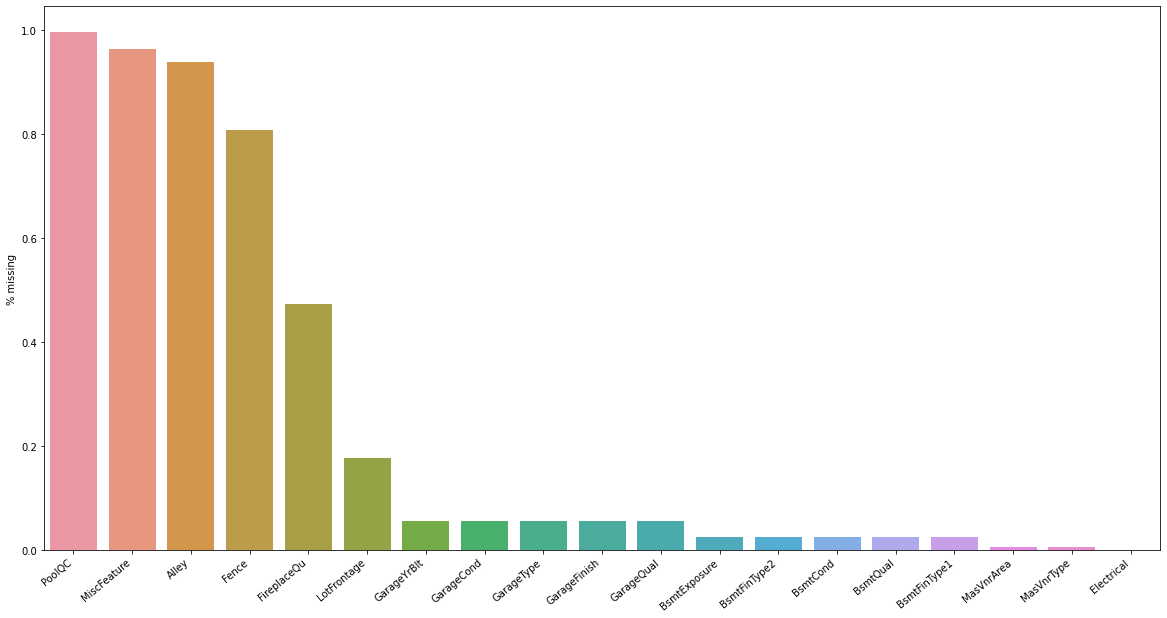

In [7]:
plt.figure(figsize=(20,10))
missing_plot = sns.barplot(x=missing.index, y=missing['% missing'])
missing_plot.set_xticklabels(missing_plot.get_xticklabels(), rotation=40, ha="right")
missing_plot

We can see that the top 4 attributes have more than 80% missing data. If we try fill in the gap somehow, the result will most likely negatively impact our model. The best course of action is to remove them completely. There is also **FireplaceQu** (Ordinal quality of fireplace), which has almost 50% missing data. To know whether or not to remove the data, we first look at its correlation with SalePrice. We use OrdinalEncoder to transform the data and calculate correlation. 

In [8]:
r_index = ['PoolQC','MiscFeature', 'Alley', 'Fence']
df_train.drop(r_index, axis=1,inplace=True)
missing.drop(r_index,axis=0,inplace=True)

In [9]:
cat=['NA','Po', 'Fa','TA','Gd','Ex']
oe = OrdinalEncoder(categories=[cat],handle_unknown='use_encoded_value',unknown_value=np.nan)
oe.fit(df_train[['FireplaceQu']])
temp = pd.DataFrame(oe.transform(df_train[['FireplaceQu']]))

df_train['SalePrice'].corr(temp.iloc[:,0])

0.29579405100682743

Fire place overall quality correlates positively (~0.3) with our target, but the correlation is relatively weak, and combine with the fact that it is missing more than 47% of data, we should remove the column entirely

In [10]:
df_train.drop('FireplaceQu',axis=1,inplace=True)
missing.drop('FireplaceQu', axis=0,inplace=True)

In [11]:
df_train['TotalArea'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']

## Imputation
For attributes with a low percentage of missing data, we will try to fill in the gap through imputation, to fix missing figures while keeping the valuable data for our predictions model. We will deploy Multivariate imputation for numeric values, where the model will look at the dataset as a whole to estimate the imputation, and most_frequent naive imputation for categorical.

In [12]:
ip = IterativeImputer(random_state=0) #Baysian estimator
si = SimpleImputer(strategy='most_frequent')
df_train_imputed = df_train.copy()
df_train_imputed[df_train.select_dtypes(include='object').columns] = si.fit_transform(df_train_imputed[df_train.select_dtypes(include='object').columns])
df_train_imputed[df_train.select_dtypes(include=np.number).columns] = ip.fit_transform(df_train_imputed[df_train.select_dtypes(include=np.number).columns])

We will check for missing value after imputation

In [13]:
df_train_imputed.isna().sum().sum() #number of missing value

0

## Analysing Target (SalePrice)
Although now we can already start building our model pipeline, It's still advantageous to perform explorative analysis on the target (SalePrice) to gain more insight. 

In [14]:
df_train_imputed['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

General descriptive statistics show that all SalePrice values are above 0, which is good for our data's integrity, As a SalePrice of 0 would almost always indicate faulty observations.

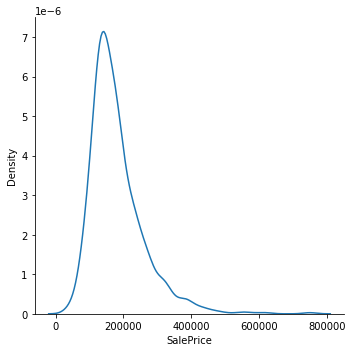

In [15]:
sns.displot(df_train_imputed['SalePrice'], kind="kde")

Seeing the distribution plot we can come to some conclusions that the data **deviate from the normal distribution.**: The distribution is not symmetrical and is more right-skewed. This would result in some models (regression-based, gra) being less likely to successfully predict the price for the most expensive houses. One way to circumvent this is by transforming our Data. Here is an example using log-transformation.

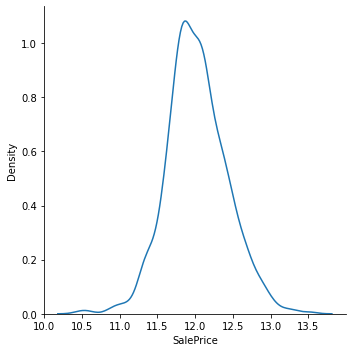

In [16]:
y = df_train_imputed['SalePrice']
logSP = np.log(y)
sns.displot(logSP, kind="kde")

After performing log-transformation, the deviation from normal distribution is much less prominent

## Correlation between SalePrice and other attributes
Next we will analyze the **relationship** between our Target and the attributes that we have chosen above. We use scatter plot for numeric attributes and boxplots for ordinal columns to draw out existing patterns.

### Grlivarea
The above grade (ground) living area in square feet


In [17]:
var = 'GrLivArea'
df_train_imputed[var].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

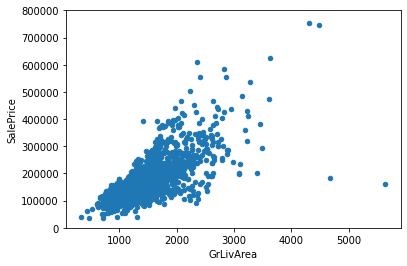

In [18]:
#scatter plot grlivarea/saleprice
data = pd.concat([df_train_imputed['SalePrice'], df_train_imputed[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

The graph above shows a positive linear relationship between Grlivarea and SalePrice

### GarageArea
Size of garage in square feet

In [19]:
var = 'GarageArea'
df_train_imputed[var].describe()

count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

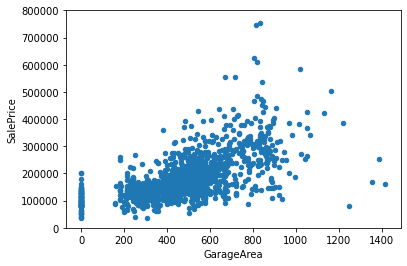

In [20]:
#scatter plot totalbsmtsf/saleprice
data = pd.concat([df_train_imputed['SalePrice'], df_train_imputed[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

- There is also a positive correlation, if slightly weaker, between GarageArea and SalePrice
- Notice a high concentration of 0. Maybe we can create a new Binary Column 'HasGarage', to emphasize the difference between houses with and without garage

### Ordinal Attributes

### OverallQual
Rating of the overall material and finish of the house, on the scale from 1 to 10, with 10 being the highest quality.

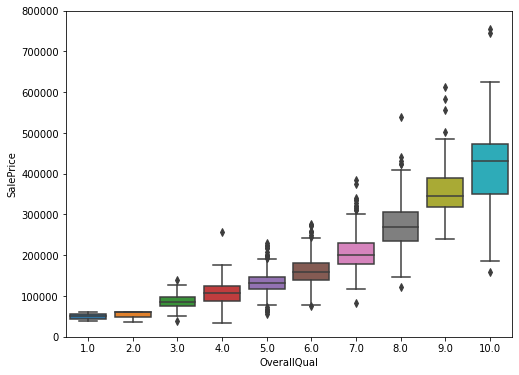

In [21]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df_train_imputed['SalePrice'], df_train_imputed[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

### YearBuilt
Original construction date

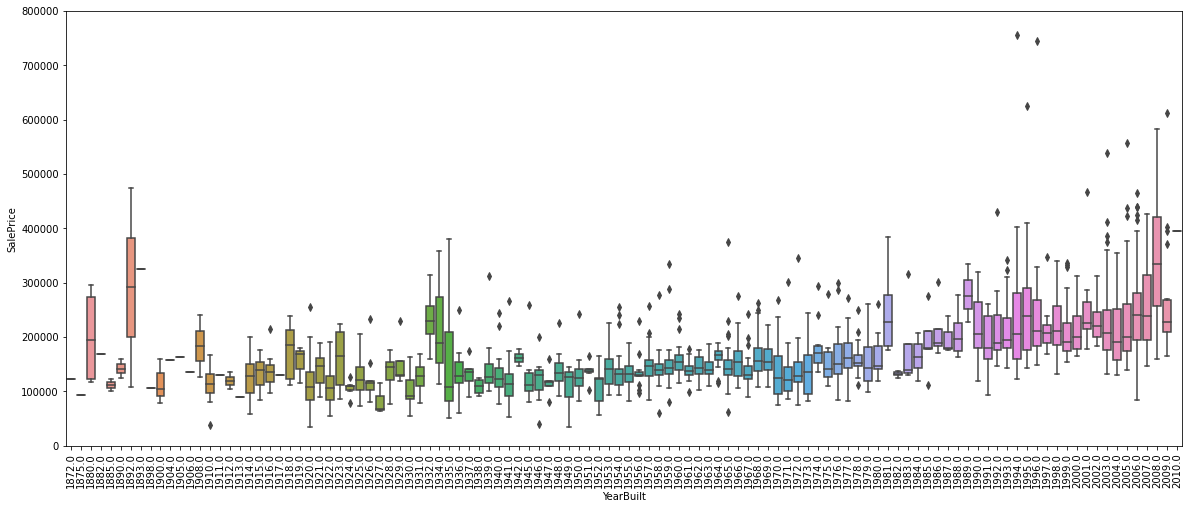

In [22]:
var = 'YearBuilt'
data = pd.concat([df_train_imputed['SalePrice'], df_train_imputed[var]], axis=1)
f, ax = plt.subplots(figsize=(20,8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

Regarding our categorical attributes, Overall Quality seems to positively affect our SalePrice as the median price at each quality point is scaling upward, while yearbuilt shows a weaker correlation. Some houses built in earlier year even have much higher SalePrice than their newer counterparts.

### In Summary
- 'GrLivArea' and 'GarageArea' seem to be linearly related with 'SalePrice'. Both relationships are positive, which means that as one variable increases, the other also increases.
- 'OverallQual' and 'YearBuilt' also seem to be related with 'SalePrice'. The relationship seems to be stronger in the case of 'OverallQual'.

## Correlation maxtrix

The first part of the analysis uses our intuition to pick out 4 attributes (GrLivArea', 'GarageArea', OverallQual','YearBuilt') to analyse relationship with SalePrice, which can sometimes be inaccurate due to human bias. The next part, using correlation matrix, we can gain a much more objective look into the relationship between our target and the other variables

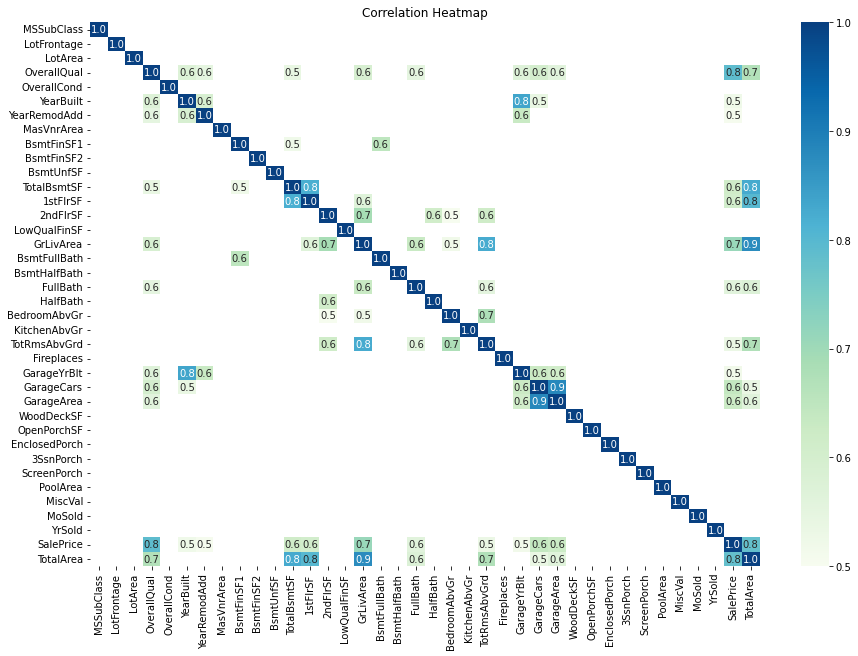

In [23]:
corr_mat = df_train_imputed.corr()

# Select correlations greater than 0.5
corr_mat = corr_mat[abs(corr_mat) >= 0.5]

# Plot correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat,
            annot=True,
            fmt='.1f',
            cmap='GnBu',
            vmin=0.5,
            vmax=1)
title = plt.title('Correlation Heatmap')

1. Regarding our target(SalePrice), we can see that there are some strong correlations with OverallQual and GrLivArea. Additionally, variables with high correlation that we have not used yet are TotalBsmtSF and FullBath

2. There also exists strong correlation between our **independent variable**, for example: between YearBuilt and GarageYrBlt, GrLivArea and TotRmsAbvGrd, GarageArea and GarageCars, TotalBsmtSF and 1stFlrSF. We can draw an seperate heatmap to see it more clearly.

Index(['SalePrice', 'OverallQual', 'TotalArea', 'GrLivArea', 'GarageCars',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd'],
      dtype='object')


<AxesSubplot:>

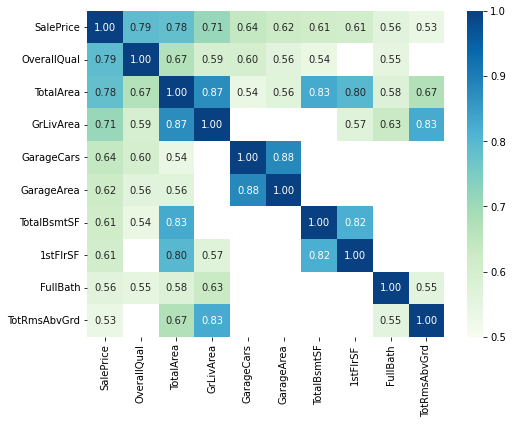

In [24]:
#picking out 10 attributes having the strongest correlation with SalePrice
cols = corr_mat.nlargest(10,'SalePrice').index 
print(cols)
corr_map=df_train_imputed[cols].corr()

corr_map=corr_map[abs(corr_map) >= 0.5] #highlighting cell with higher than .5 correlation

plt.figure(figsize=(8,6))
sns.heatmap(corr_map,
            annot=True,
            fmt='.2f',
            cmap='GnBu',
            vmin=0.5,
            vmax=1)

## IMLPEMENTING MODEL

After processing missing values and performing explorative look through our data, we next build our prediction model using XGBoost and evaluate the prediction using root-mean-squared-error (rmse).
These are the steps that will be deployed:
- Ordinal encode ordinal columns
- One-hot encode nominal columns
- Set model parameters
- Evaluate prediction

#### Ordinal and One-Hot encoding

In [25]:
# list of ordinal columns
ordinal_col = ['LotShape', 'Utilities','OverallQual', 'OverallCond', 'ExterCond', 
                'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']
nominal_col = df_train_imputed.select_dtypes(include='object').columns
nominal_col= [i for i in nominal_col if i not in ordinal_col]
num_col = df_train_imputed.drop('SalePrice', axis=1).select_dtypes(include=np.number).columns

#Setting encoder parameters
OE = OrdinalEncoder()
OHE = OneHotEncoder(handle_unknown='ignore')
si = SimpleImputer()

#Transformer for pipeline
cat_encode = ColumnTransformer([('ordinal', OE, ordinal_col),
                             ('one-hot', OHE, nominal_col)],remainder='passthrough')


In [26]:
y = df_train_imputed['SalePrice']
X_ = df_train_imputed.drop('SalePrice', axis=1)
X = X_.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
model = XGBRegressor(n_estimators=400,learning_rate=0.03)
pipe = Pipeline(steps=[('transform', cat_encode),
                      ('estimate', model)])

In [27]:
pipe.fit(X_train, y_train)

# pipe.fit(X_train, y_train)
# scores = pipe.predict(X_test)
# mean_absolute_error(scores, y_test)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal', OrdinalEncoder(),
                                                  ['LotShape', 'Utilities',
                                                   'OverallQual', 'OverallCond',
                                                   'ExterCond', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'GarageQual',
                                                   'GarageCond']),
                                                 ('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['...
                  

In [28]:
score = pipe.predict(X_test)
mean_absolute_error(score, y_test)

15556.001518354024

#### Trying out regression models

In [30]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.compose import TransformedTargetRegressor

Rmodel = Ridge(alpha=20)
wrapped_model = TransformedTargetRegressor(regressor=Rmodel, transformer=StandardScaler())
SS = ColumnTransformer([('standardize', StandardScaler(), num_col)])

#Transformer for pipeline
cat_encode = ColumnTransformer([('ordinal', OE, ordinal_col),
                             ('one-hot', OHE, nominal_col),
                               ('SS', SS, num_col)],remainder='passthrough')



pipe_2 = Pipeline(steps=[('transform', cat_encode),
                         ('estimate', wrapped_model)])
pipe_2.fit(X_train, y_train)
score = pipe_2.predict(X_test)

mean_absolute_error(score, y_test)

18777.62354383498